# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
64 nodes added Convolutional AE, 128x128x3

## 0. Setting

### Goole Drive Connecting

In [1]:
pwd

'/Users/haesik/AISCHOOL/Final_Project/img'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [ ]:
!ls

 data  'Fashion Recommendation System0810.ipynb'   figure  'low version'


In [ ]:
!unzip Fashion_train_modelimages.zip

In [ ]:
!unzip Fashion_train_itemimages.zip

### Library Call

In [ ]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pydot

In [ ]:
pip install graphviz

In [2]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras import layers, models
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [ ]:
import os
os.getcwd()

'/Users/haesik/AISCHOOL/Final_Project/img'

In [3]:
root_dir = '/Users/haesik/AISCHOOL/Final_Project/img/Item-Image/'
# glob(f'{root_dir}/*.jpg')

In [89]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 128
imgC = 128
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/Users/haesik/AISCHOOL/Final_Project/img/Item-Image/'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# Load All img from folder
def load_img_folder():
    # 의상의 전방부 사진만 가져오기
    wfiles = sorted(glob(f'{root_dir}/*_F.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# -------------Image EDA & Visualization ------------- #
# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()

# ------------- Model Function ------------- #
# Reconstruction Error Function Definition
def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

# Average Pooling Fuction Definition
def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

# ------------- Recommendation System ------------- #
def Fashion_coordination(top10_result, fashion_df):
  result_df = []
  for item in top10_result:
    ele_df = pd.DataFrame(columns=fashion_df.columns)
    for col in fashion_df.columns:
      ele = fashion_df[fashion_df[col] == item]
      ele_df = pd.concat([ele_df,ele])
    result_df.append(ele_df)
  return result_df

## 1. Data Load

In [5]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (16585, 128, 128, 3)
label_set.shape : 16585


In [6]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 215.1488)

In [7]:
# Label Information
type(label_set), label_set[:4]

(list, ['0928015_F.jpg', '0929029_F.jpg', '1008001_F.jpg', '1008004_F.jpg'])

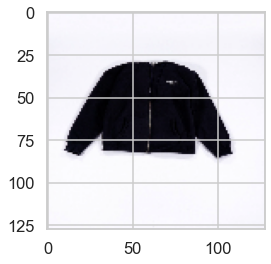

In [8]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

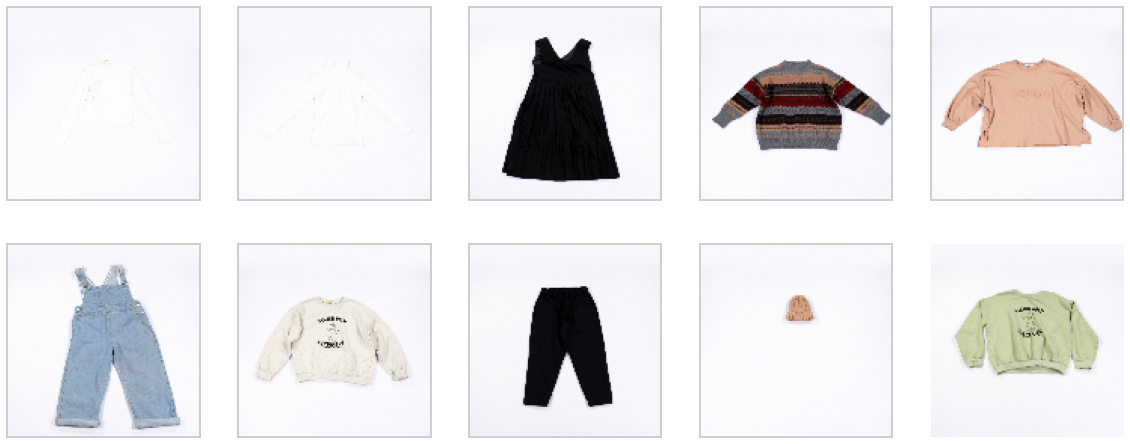

In [9]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [10]:
# Data Normalization
img_scaled = img_set / 255.0
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (16585, 128, 128, 3) 215.1488384048635
Scaled Image Format : (16585, 128, 128, 3) 0.8437209349210284


In [11]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(13268, 128, 128, 3) 13268
(3317, 128, 128, 3) 3317


## 3. Convolutional Autoencoder Modeling

### Encoder

In [13]:
# Encoder Part Modeling
tf.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

# Fisrt ConvPooling Layer : 128
L1 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)

# Second ConvPooling Layer : 64
L3 = Conv2D(64, (3, 3), activation='relu', padding='same')(L2)
L4 = Conv2D(64, (3, 3), activation='relu', padding='same')(L3)
L5 = BatchNormalization()(L4)
L6 = MaxPooling2D((2, 2))(L5)

# Third ConvPooling Layer : 32
L7 = Conv2D(32, (3, 3), activation='relu', padding='same')(L6)
L8 = Conv2D(32, (3, 3), activation='relu', padding='same')(L7)
L9 = BatchNormalization()(L8)
L10 = MaxPooling2D((2, 2))(L9)

# Fourth ConvPooling Layer : 16
L11 = Conv2D(16, (3, 3), activation='relu', padding='same')(L10)
L12 = Conv2D(16, (3, 3), activation='relu', padding='same')(L11)
L13 = BatchNormalization()(L12)
L14 = MaxPooling2D((2, 2))(L13)

# Fifth ConvPooling Layer : 8
L15 = Conv2D(8, (3, 3), activation='relu', padding='same')(L14)
L16 = MaxPooling2D((2, 2))(L15)

encoder_output = L16

2022-08-18 10:29:13.908271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 10:29:13.909265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [15]:
# Encoder Summary()
encoder = tf.keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0     

In [16]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Decoder

In [18]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

# First ConvPooling Layer : 8
L17 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L18 = UpSampling2D((2, 2))(L17)

# Second ConvPooling Layer : 16
L19 = Conv2D(16, (3, 3), activation='relu', padding='same')(L18)
L20 = Conv2D(16, (3, 3), activation='relu', padding='same')(L19)
L21 = BatchNormalization()(L20)
L22 = UpSampling2D((2, 2))(L21)

# Third ConvPooling Layer : 32
L23 = Conv2D(32, (3, 3), activation='relu', padding='same')(L22)
L24 = Conv2D(32, (3, 3), activation='relu', padding='same')(L23)
L25 = BatchNormalization()(L24)
L26 = UpSampling2D((2, 2))(L25)

# Fourth ConvPooling Layer : 64
L27 = Conv2D(64, (3, 3), activation='sigmoid', padding='same')(L26)
L28 = Conv2D(64, (3, 3), activation='relu', padding='same')(L27)
L29 = BatchNormalization()(L28)
L30 = UpSampling2D((2, 2))(L29)

# Fifth ConvPooling Layer : 128
L31 = Conv2D(128, (3, 3), activation='sigmoid', padding='same')(L30)
L32 = UpSampling2D((2, 2))(L31)

# Sixth ConvPooling Layer : 3
L33 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L32)

decoder_output = L33

In [20]:
# Decoder Summary()
decoder = tf.keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 4, 8)]         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 16)          1168      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 16)          64        
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 16, 16, 16)        0   

In [21]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### AutoEncoder (Encoder + Decoder)

In [23]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = tf.keras.Model(init_input, connect_output)

In [24]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [25]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 4, 4, 8)           150568    
_________________________________________________________________
model_1 (Functional)         (None, 128, 128, 3)       151147    
Total params: 301,715
Trainable params: 301,267
Non-trainable params: 448
_________________________________________________________________


In [26]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0818.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [27]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [28]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 64

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|  0/100 ETA: ?s,  ?epoch

Epoch 1/100
Epoch 1/100


2022-08-18 10:30:19.781081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-18 10:30:19.790802: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0/197                        ETA: ?s - 

2022-08-18 10:30:20.905003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.2516

2022-08-18 10:32:34.338373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 137s 666ms/step - loss: 0.2516 - val_loss: 0.3194

Epoch 00001: val_loss improved from inf to 0.31936, saving model to Training-checkpoint/cp-0001-0.32.ckpt
Epoch 2/100
Epoch 2/100


0/197                        ETA: ?s - 

197/197 [==============================] - 128s 650ms/step - loss: 0.2295 - val_loss: 0.2523

Epoch 00002: val_loss improved from 0.31936 to 0.25230, saving model to Training-checkpoint/cp-0002-0.25.ckpt
Epoch 3/100
Epoch 3/100


0/197                        ETA: ?s - 

197/197 [==============================] - 127s 646ms/step - loss: 0.2263 - val_loss: 0.2401

Epoch 00003: val_loss improved from 0.25230 to 0.24009, saving model to Training-checkpoint/cp-0003-0.24.ckpt
Epoch 4/100
Epoch 4/100


0/197                        ETA: ?s - 

197/197 [==============================] - 128s 647ms/step - loss: 0.2238 - val_loss: 0.2846

Epoch 00004: val_loss did not improve from 0.24009
Epoch 5/100
Epoch 5/100


0/197                        ETA: ?s - 

197/197 [==============================] - 123s 624ms/step - loss: 0.2225 - val_loss: 0.2366

Epoch 00005: val_loss improved from 0.24009 to 0.23656, saving model to Training-checkpoint/cp-0005-0.24.ckpt
Epoch 6/100
Epoch 6/100


0/197                        ETA: ?s - 

197/197 [==============================] - 124s 627ms/step - loss: 0.2221 - val_loss: 0.2273

Epoch 00006: val_loss improved from 0.23656 to 0.22729, saving model to Training-checkpoint/cp-0006-0.23.ckpt
Epoch 7/100
Epoch 7/100


0/197                        ETA: ?s - 

197/197 [==============================] - 123s 625ms/step - loss: 0.2208 - val_loss: 0.2260

Epoch 00007: val_loss improved from 0.22729 to 0.22596, saving model to Training-checkpoint/cp-0007-0.23.ckpt
Epoch 8/100
Epoch 8/100


0/197                        ETA: ?s - 

197/197 [==============================] - 124s 629ms/step - loss: 0.2201 - val_loss: 0.2907

Epoch 00008: val_loss did not improve from 0.22596
Epoch 9/100
Epoch 9/100


0/197                        ETA: ?s - 

197/197 [==============================] - 124s 628ms/step - loss: 0.2195 - val_loss: 0.2268

Epoch 00009: val_loss did not improve from 0.22596
Epoch 10/100
Epoch 10/100


0/197                        ETA: ?s - 

197/197 [==============================] - 123s 623ms/step - loss: 0.2187 - val_loss: 0.2510

Epoch 00010: val_loss did not improve from 0.22596
Epoch 11/100
Epoch 11/100


0/197                        ETA: ?s - 

197/197 [==============================] - 123s 624ms/step - loss: 0.2191 - val_loss: 0.2406

Epoch 00011: val_loss did not improve from 0.22596
Epoch 12/100
Epoch 12/100


0/197                        ETA: ?s - 

197/197 [==============================] - 125s 634ms/step - loss: 0.2178 - val_loss: 0.2305

Epoch 00012: val_loss did not improve from 0.22596
Epoch 13/100
Epoch 13/100


0/197                        ETA: ?s - 

197/197 [==============================] - 125s 633ms/step - loss: 0.2179 - val_loss: 0.2300

Epoch 00013: val_loss did not improve from 0.22596
Epoch 14/100
Epoch 14/100


0/197                        ETA: ?s - 

197/197 [==============================] - 124s 628ms/step - loss: 0.2174 - val_loss: 0.2709

Epoch 00014: val_loss did not improve from 0.22596
Epoch 15/100
Epoch 15/100


0/197                        ETA: ?s - 

197/197 [==============================] - 129s 657ms/step - loss: 0.2171 - val_loss: 0.2288

Epoch 00015: val_loss did not improve from 0.22596
Epoch 16/100
Epoch 16/100


0/197                        ETA: ?s - 

197/197 [==============================] - 127s 645ms/step - loss: 0.2175 - val_loss: 0.2261

Epoch 00016: val_loss did not improve from 0.22596
Epoch 17/100
Epoch 17/100


0/197                        ETA: ?s - 

197/197 [==============================] - 128s 650ms/step - loss: 0.2173 - val_loss: 0.2363

Epoch 00017: val_loss did not improve from 0.22596


In [31]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:36:02


In [32]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.tail()

,loss,val_loss
12,0.217914,0.230044
13,0.217434,0.270881
14,0.217140,0.228846
15,0.217497,0.226053
16,0.217277,0.236322


In [33]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
6,0.220832,0.225964


In [34]:
# encoder.save('model_save/Encoder_0818.h5')

In [35]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0818/')
# tf.keras.models.save_model(encoder, 'model_save/Encoder_0818/')

# Decoder Part Save
decoder.save('model_save/Decoder_0818/')
# tf.keras.models.save_model(decoder, 'model_save/Decoder_0818/')


# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0818/')
# tf.keras.models.save_model(model, 'model_save/ConvAE_0818/')


2022-08-18 11:10:15.241587: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_save/Encoder_0818/assets
INFO:tensorflow:Assets written to: model_save/Decoder_0818/assets
INFO:tensorflow:Assets written to: model_save/ConvAE_0818/assets


In [36]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0818/')
decoder = keras.models.load_model('model_save/Decoder_0818/')
model = keras.models.load_model('model_save/ConvAE_0818/')

## 4. Performance Evaluation

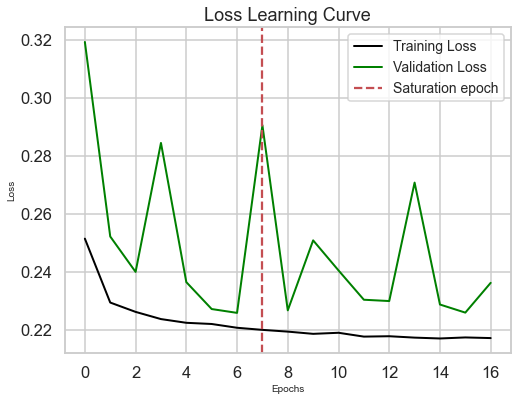

In [38]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
# plt.savefig('figure/learning_curve.png')
plt.show()

In [41]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

2022-08-18 11:11:16.146645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 11s 102ms/step - loss: 0.2330
test loss : 0.233


In [42]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

2022-08-18 11:11:27.294481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


((3317, 128, 128, 3), 0.8486)

<Figure size 432x288 with 0 Axes>

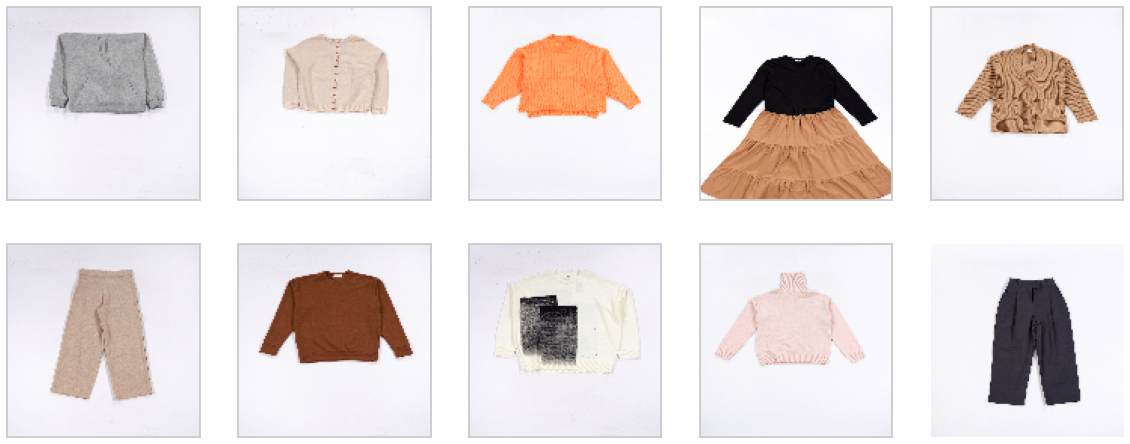

In [43]:
# Test Image Samples
_ = plot_images(2,5,X_test)

<Figure size 432x288 with 0 Axes>

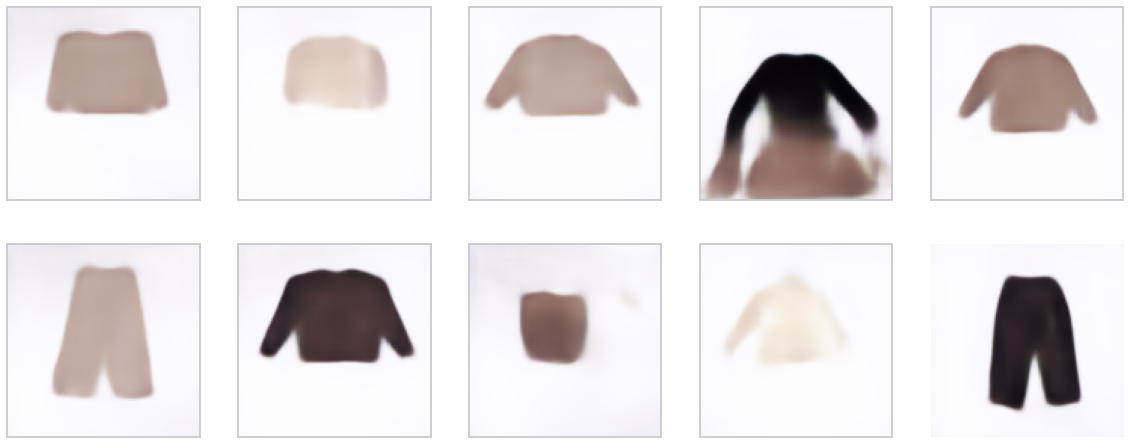

In [44]:
# Prediction Image Samples
_ = plot_images(2,5,X_pred)

In [45]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(3317, list)

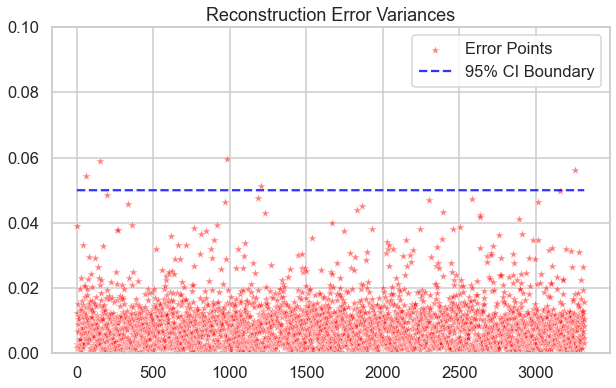

In [46]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [47]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

2022-08-18 11:12:17.627126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


((16585, 4, 4, 8), numpy.ndarray)

In [48]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((16585, 8), numpy.ndarray)

In [49]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.483500,0.041676,0.940710,0.417254,4.501226,0.023833,0.012728,0.503558,0928015_F.jpg
1,0.492400,0.045830,0.943731,0.413210,4.315616,0.029560,0.019921,0.486702,0929029_F.jpg
2,2.040671,5.314354,3.429888,4.723020,5.121839,7.019668,0.706738,5.880388,1008001_F.jpg
3,1.902746,3.381134,1.972022,3.867881,4.655611,4.625994,0.878618,4.364405,1008004_F.jpg
4,1.384872,2.239316,1.362207,2.924938,3.928515,2.604115,0.628851,2.822891,1008006_F.jpg


In [50]:
# Latent Feature DataFrame export to csv
df.to_csv('latent_feature_0818.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [51]:
# Latent Feature DataFrame load
df = pd.read_csv('latent_feature_0818.csv')
print(df.shape)
df.head()

(16585, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,0.483500,0.041676,0.940710,0.417254,4.501226,0.023833,0.012728,0.503558,0928015_F.jpg
1,0.492400,0.045830,0.943731,0.413210,4.315616,0.029560,0.019921,0.486702,0929029_F.jpg
2,2.040671,5.314354,3.429888,4.723020,5.121839,7.019668,0.706738,5.880388,1008001_F.jpg
3,1.902746,3.381134,1.972022,3.867881,4.655611,4.625994,0.878618,4.364405,1008004_F.jpg
4,1.384872,2.239316,1.362207,2.924938,3.928515,2.604115,0.628852,2.822891,1008006_F.jpg


In [53]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(16585, 8) (16585,)


### Cosine Similarity

In [54]:
data = data.astype('float32')

In [55]:
# Cosine Similarity Computation
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(data, data)
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

cosine_matrix.shape : (16585, 16585)


array([[1.0000001 , 0.9999322 , 0.5245525 , 0.60515505],
       [0.9999322 , 1.0000001 , 0.5291964 , 0.6092986 ],
       [0.5245525 , 0.5291964 , 1.0000001 , 0.9890759 ],
       [0.60515505, 0.6092986 , 0.9890759 , 1.        ]], dtype=float32)

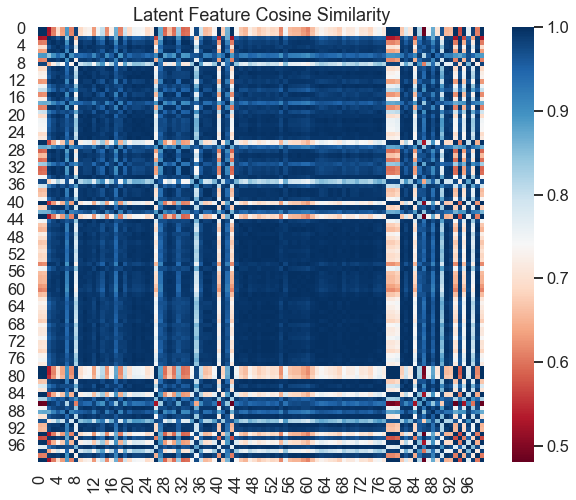

In [56]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [57]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

sample_idx : 15795


In [58]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 16585)


In [59]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [60]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (16585, 1)


,sample
0,0.984373
1,0.985824
2,0.637006
3,0.707380


In [61]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
top10_label_cosine = label[top10_idx_cosine].values
print('top10_idx_cosine :',top10_idx_cosine)
print(top10_label_cosine)

top10_idx_cosine : Int64Index([15795, 13457, 15675, 15451, 8793, 8813, 14988, 3849, 15434, 15596], dtype='int64')
['1210461_F.jpg' '1201100_F.jpg' '1210288_F.jpg' '1209324_F.jpg'
 '1112443_F.jpg' '1112471_F.jpg' '1207505_F.jpg' '1027278_F.jpg'
 '1209303_F.jpg' '1210177_F.jpg']


1210461_F.jpg


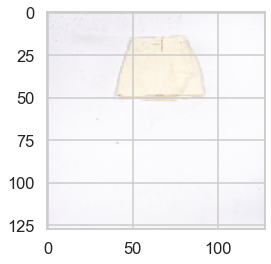

In [62]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

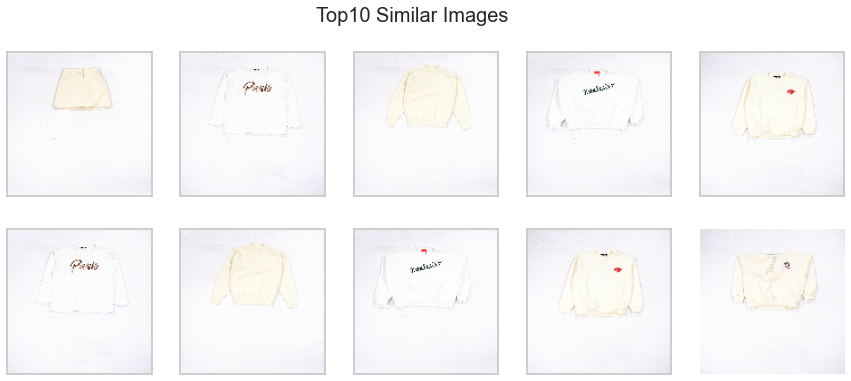

In [63]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [64]:
# Euclidean Distance Calculation
from sklearn.metrics.pairwise import euclidean_distances

ec_matrix = 1 / euclidean_distances(data, data)
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

ec_matrix.shape : (16585, 16585)


array([[       inf, 5.349691  , 0.08649006, 0.12599187],
       [5.349691  ,        inf, 0.08639165, 0.12586614],
       [0.08649006, 0.08639165,        inf, 0.25917011],
       [0.12599187, 0.12586614, 0.25917011,        inf]], dtype=float32)

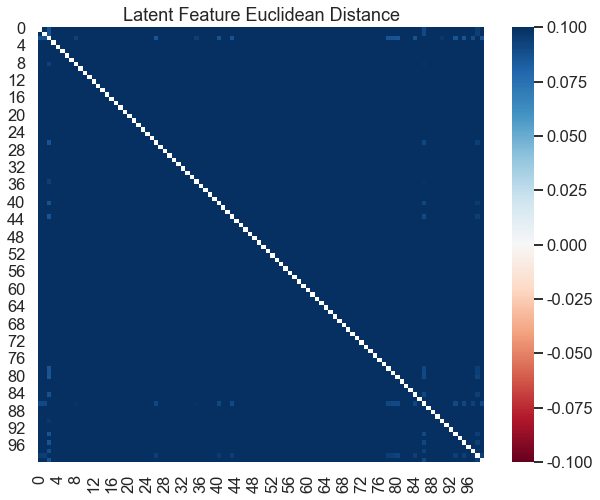

In [65]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [66]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 16585)


In [67]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (16585, 1)


,sample
0,1.015179
1,1.189766
2,0.089527
3,0.132689


In [68]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([15795, 15675, 15434, 14988, 16555, 16563, 7782, 13558, 15451,
            13466],
           dtype='int64')
['1210461_F.jpg' '1210288_F.jpg' '1209303_F.jpg' '1207505_F.jpg'
 '1211639_F.jpg' '1211648_F.jpg' '1110416_F.jpg' '1201261_F.jpg'
 '1209324_F.jpg' '1201110_F.jpg']


1210461_F.jpg


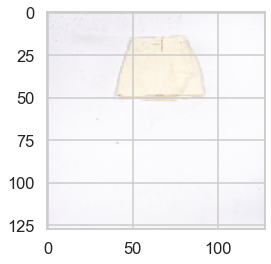

In [69]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

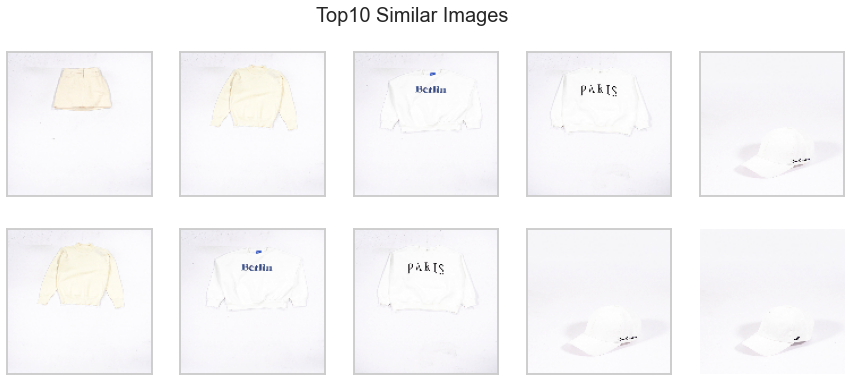

In [70]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [71]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

pearson_sim.shape : (16585, 16585)


array([[1.        , 0.99995224, 0.13482404, 0.36925691],
       [0.99995224, 1.        , 0.13077281, 0.36428708],
       [0.13482404, 0.13077281, 1.        , 0.93498605],
       [0.36925691, 0.36428708, 0.93498605, 1.        ]])

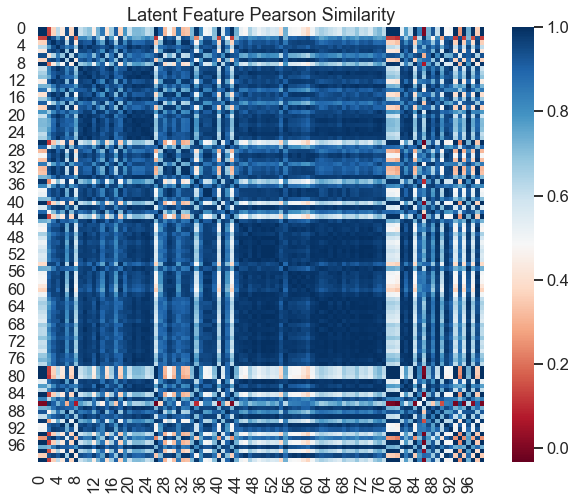

In [72]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [73]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

sample_pearson_sim.shape : (16586, 16586)


In [74]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

df_pearson.shape : (16585, 1)


,sample
0,0.991651
1,0.992103
2,0.171777
3,0.394188


In [75]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

top10_idx_pearson : Int64Index([15795, 13457, 15761, 7667, 13558, 12865, 15675, 8813, 13466,
            15596],
           dtype='int64')
['1210461_F.jpg' '1201100_F.jpg' '1210419_F.jpg' '1110262_F.jpg'
 '1201261_F.jpg' '1127080_F.jpg' '1210288_F.jpg' '1112471_F.jpg'
 '1201110_F.jpg' '1210177_F.jpg']


1210461_F.jpg


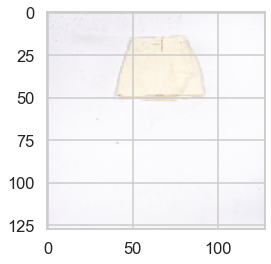

In [76]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

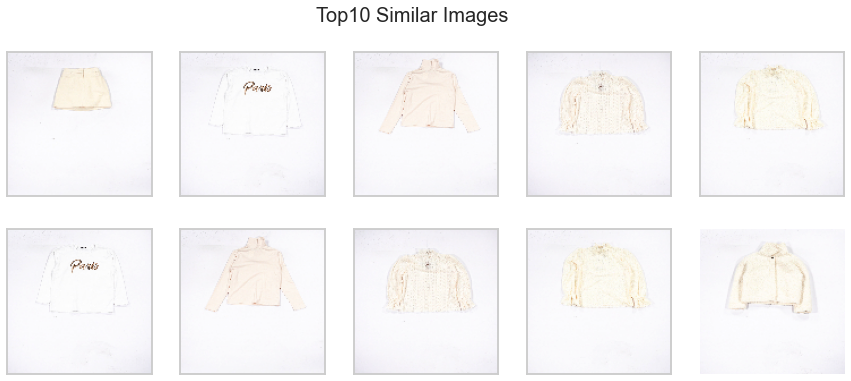

In [77]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)

## 7. Fashion Coordination Recommendation

### Fashion Coordination Dataframe Design

In [81]:
# fashion coordination dataframe
fashion_df = pd.read_csv('fashion data/uni_wearing.csv')
print('fashion_df.shape :',fashion_df.shape)
fashion_df.head()

fashion_df.shape : (18040, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013.0,1008011,NaN,1008012.0,NaN
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449.0,1029157,NaN,1029107.0,NaN
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442.0,1029411,NaN,1029109.0,NaN
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434.0,1029073,NaN,1029141.0,NaN
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431.0,1029255,NaN,1029142.0,NaN


In [82]:
# fashion dataframe Information
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wearing    18040 non-null  object 
 1   hat        32 non-null     float64
 2   main_top   18040 non-null  int64  
 3   inner_top  2838 non-null   float64
 4   bottom     16224 non-null  float64
 5   shoes      125 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 845.8+ KB


In [83]:
# fashion dataframe 
print(fashion_df.isna().sum())

wearing          0
hat          18008
main_top         0
inner_top    15202
bottom        1816
shoes        17915
dtype: int64


In [84]:
# fashion dataframe Missing Value Imputation
fashion_df.fillna(0,inplace=True)
print('Remain Missing Value :',fashion_df.isna().sum().sum())

Remain Missing Value : 0


In [85]:
# fashion data preprocessing
fashion_df.iloc[:,1:] = fashion_df.iloc[:,1:].astype(int)
fashion_df.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442,1029411,0,1029109,0
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434,1029073,0,1029141,0
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431,1029255,0,1029142,0


### Match the coordination

In [86]:
# top10 label by cosine similarity
top10_label_cosine

array(['1210461_F.jpg', '1201100_F.jpg', '1210288_F.jpg', '1209324_F.jpg',
       '1112443_F.jpg', '1112471_F.jpg', '1207505_F.jpg', '1027278_F.jpg',
       '1209303_F.jpg', '1210177_F.jpg'], dtype=object)

In [87]:
# top10 label preprocessing
top10_result_cosine = list(map(lambda x : int(x[:7]), top10_label_cosine))
top10_result_cosine

[1210461,
 1201100,
 1210288,
 1209324,
 1112443,
 1112471,
 1207505,
 1027278,
 1209303,
 1210177]

In [90]:
# top10 Recommendation Result
recomm_df = Fashion_coordination(top10_result_cosine, fashion_df)
print('recomm_df :',len(recomm_df),'DataFrame')
for i in range(len(recomm_df)):
  print(f"{i+1} item's coordination cases :",recomm_df[i].shape[0])

recomm_df : 10 DataFrame
1 item's coordination cases : 3
2 item's coordination cases : 2
3 item's coordination cases : 2
4 item's coordination cases : 1
5 item's coordination cases : 1
6 item's coordination cases : 2
7 item's coordination cases : 1
8 item's coordination cases : 2
9 item's coordination cases : 1
10 item's coordination cases : 1


In [91]:
# First Similar Item Coordination Info
recomm_df[0].head()

,wearing,hat,main_top,inner_top,bottom,shoes
17544,1210_1210_720_B_B117_620_627_B117_000.jpg,0,1210008,0,1210461,0
17545,1210_1210_720_B_B119_620_627_B119_000.jpg,0,1210007,0,1210461,0
17546,1210_1210_720_B_B120_622_627_B120_000.jpg,0,1210046,0,1210461,0


### Recommendation Service Output Result

In [100]:
pwd

'/Users/haesik/AISCHOOL/Final_Project/img'

In [99]:
root_dir

'/Users/haesik/AISCHOOL/Final_Project/img/Item-Image/'

In [110]:
model_dir = '/Users/haesik/AISCHOOL/Final_Project/img/Model-Image/'

In [114]:
recomm_df[0]

,wearing,hat,main_top,inner_top,bottom,shoes
17544,1210_1210_720_B_B117_620_627_B117_000.jpg,0,1210008,0,1210461,0
17545,1210_1210_720_B_B119_620_627_B119_000.jpg,0,1210007,0,1210461,0
17546,1210_1210_720_B_B120_622_627_B120_000.jpg,0,1210046,0,1210461,0


In [107]:
import glob

glob.glob(model_dir)

[]

In [119]:
img_read(model_dir + '1210_1210_720_B_B117_620_627_B117_000.jpg')

[ WARN:0@4166.900] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/haesik/AISCHOOL/Final_Project/img/Model-Image/1210_1210_720_B_B117_620_627_B117_000.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


[ WARN:0@4263.919] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/haesik/AISCHOOL/Final_Project/img/Model-Image/1210_1210_720_A_A133_624_627_A133_000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4263.941] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/haesik/AISCHOOL/Final_Project/img/Model-Image/1028_1028_720_B_B056_204_192_B056_000.jpg'): can't open/read file: check file path/integrity


<Figure size 432x288 with 0 Axes>

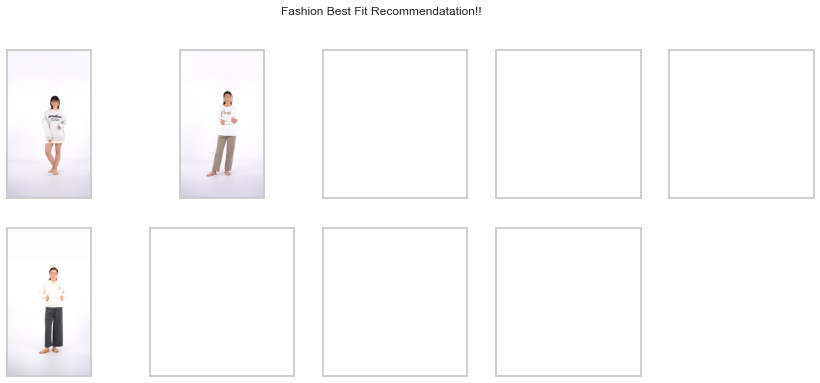

In [123]:
count = 0
fig = plt.figure()
fig, ax = plt.subplots(2,5,figsize=(5*3,2*3))
plt.suptitle('Fashion Best Fit Recommendatation!!')
for i in range(2):
  for j in range(5):
    axis = ax[i,j]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    try:
        fashion_img_name = recomm_df[count].iloc[1,0]
        img = img_read(model_dir + fashion_img_name)
        axis.imshow(img)
        plt.axis('off')
    except:
      pass
    count+=1
    
plt.show()